In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import torch
from torch import nn
from torch import optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch.nn.functional as F
import torchvision

In [ ]:
#pip install torch torchvision

## GPUを使える場合はGPUを使うための準備
Google coraboratoryを使用する場合はGPUを使用してください。
今回はPC上で使用するのでCPUを使用します。

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cpu


## 多層パーセプトロンでの画像分類をPyTorchで実装する際のステップは以下の通り
- step1: データの読み込み
- step2: ネットワークの定義
- step3: 損失関数の定義 
- step4: 最適化関数の定義
- step5: 学習（講義コードはここまで）
- step6: 学習したネットワークを使って未知データの予測

## step1: データの読み込み

In [ ]:
#!wget https://datamix-advance-deeplearning.s3-ap-northeast-1.amazonaws.com/+day3/food_data.zip
#!unzip food_data.zip 

### DataLoaderを作成
---

DataLoaderを作成し、forループでデータの一部のみを受け取れるようにします。

datasets.ImageFolderは、画像がクラスごとに別れて格納されていると、(画像,targetラベル)といったタプル型のリストを生成してくれます。

In [3]:
transform = transforms.Compose(
    [transforms.RandomResizedCrop(100, scale=(1.0, 1.0), ratio=(1.0, 1.0)),
     transforms.ToTensor()])

imageset = datasets.ImageFolder(root='./food_data/train',
                                transform=transform)

train_size = int(0.85 * len(imageset))
valid_size = len(imageset) - train_size
trainset, validset = torch.utils.data.random_split(
    imageset, [train_size, valid_size])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=32,
                                          shuffle=False)

(410, 818, 3)


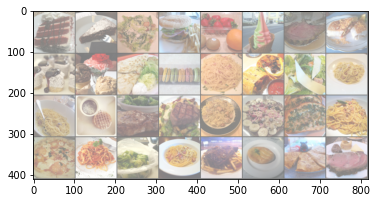

Dessert Dessert Vegetable-Fruit Bread Vegetable-Fruit Dessert  Meat Bread Dessert Dessert Bread Dessert Noodles-Pasta Bread Vegetable-Fruit Noodles-Pasta Noodles-Pasta Dessert  Meat  Meat Noodles-Pasta Dessert Bread Noodles-Pasta Bread Noodles-Pasta Vegetable-Fruit Noodles-Pasta  Meat Bread Bread  Meat


In [4]:
classes = ['Bread', 'Dessert', 'Meat', 'Noodles-Pasta',  'Vegetable-Fruit']


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get a batch of training data
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

## Step2:  ネットワークの定義

In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        sizes = x.size()
        return x.view(sizes[0], -1)

In [6]:
net = nn.Sequential(
    nn.Conv2d(3, 28, 3, 1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=28, out_channels=32, kernel_size=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    Flatten()
)

In [7]:
sample_data = torch.rand([10, 3, 100, 100])
sample_data.shape

torch.Size([10, 3, 100, 100])

In [8]:
print(net(sample_data).shape)

torch.Size([10, 18432])


In [9]:
net = nn.Sequential(
    nn.Conv2d(3, 28, 3, 1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=28, out_channels=32, kernel_size=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    Flatten(),
    nn.Linear(18432, 100),
    nn.ReLU(),
    nn.Linear(100, 5)
)

### GPUに転送
---
GPUはCPUと違って、計算処理を順番に行うのではなく、並行化して行うことができます。<br>
Deep Learningでは膨大な量の行列計算を行うので、GPUを利用し並列化して計算を行うと高速化が見込めます。

In [10]:
net = net.to(device)

## Step3: 目的関数に交差エントロピー誤差関数を用意（損失関数の定義）

In [11]:
loss_func = nn.CrossEntropyLoss()
print(loss_func)

CrossEntropyLoss()


## Step4: Optimizerを定義する（最適化関数の定義）
---
今回はSGDを利用します。

In [12]:
optimizer = optim.SGD(net.parameters(), lr=0.01)

## step5: 学習

In [13]:
train_loss_track = []
valid_loss_track = []

epoc_num = 5

for epoc in range(epoc_num):
    running_loss = 0
    running_valid_loss = 0

    # 学習モード
    net.train()
    for step, (xx, yy) in enumerate(trainloader):

        # device = "cuda"の場合、GPUにデータを転送する
        xx = xx.to(device)
        yy = yy.to(device)

        # 最後に計算した各パラメーターの勾配を初期化する
        optimizer.zero_grad()

        # フォワード計算を行う
        y_pred = net.forward(xx)

        # 誤差関数を使ってギャップの計測
        loss = loss_func(y_pred, yy)

        # 誤差逆伝播法を使って自動微分
        loss.backward()

        # パラメーターを更新
        optimizer.step()

        # 学習データを使って損失を計算
        running_loss += loss.item()

        if step % 50 == 0:
            print('[{:d}, {:5d}] loss: {}'.format(
                epoc + 1, step + 1, running_loss / 50))
            running_loss = 0.0

    # エポックが終了したら平均損失を計算
    train_loss_track.append(running_loss/step)

    # 評価（evaluation）モード
    net.eval()

    with torch.no_grad():
        for step, (xx_valid, yy_valid) in enumerate(validloader):

            # device = "cuda"の場合、GPUにデータを転送する
            xx_valid = xx_valid.to(device)
            yy_valid = yy_valid.to(device)

            # 予測値を計算
            y_pred = net(xx_valid)

            # 誤差関数を使ってギャップの計測
            valid_loss = loss_func(y_pred, yy_valid)

            # テストデータを使って損失を計算
            running_valid_loss += valid_loss.item()

        # 誤差をトラッキング
        valid_loss_track.append(running_valid_loss / (step + 1))

[1,     1] loss: 0.032392296791076663
[1,    51] loss: 1.608465588092804
[2,     1] loss: 0.03197010517120361
[2,    51] loss: 1.601809525489807
[3,     1] loss: 0.03182503223419189
[3,    51] loss: 1.5915338540077208
[4,     1] loss: 0.03159892797470093
[4,    51] loss: 1.5780226707458496
[5,     1] loss: 0.031193647384643555
[5,    51] loss: 1.555864372253418


### 交差エントロピー誤差の推移

In [ ]:
plt.plot(train_loss_track)

In [ ]:
plt.plot(valid_loss_track)

In [ ]:
true = 0
total = 0

all_labels = np.array([])
all_preds = np.array([])

with torch.no_grad():
    for valid_xx, valid_yy in validloader:

        # device = "cuda"の場合、GPUにデータを転送する
        valid_xx = valid_xx.to(device)
        valid_yy = valid_yy.to(device)

        outputs = net(valid_xx)
        _, predicted = torch.max(outputs.data, 1)

        all_labels = np.append(all_labels, valid_yy.cpu().data.numpy())
        all_preds = np.append(all_preds, predicted.cpu().numpy())

        total += valid_yy.size(0)
        true += (predicted == valid_yy).sum().item()
print('Accuracy: {:.2f} %'.format(100 * float(true/total)))

In [ ]:
labels = np.unique(all_labels)
cm = confusion_matrix(all_labels, all_preds, labels=labels)
cm_labeled = pd.DataFrame(cm, columns=labels, index=labels)
cm_labeled

## step6: 学習したネットワークを使って未知データの予測

In [ ]:
testset = datasets.ImageFolder(root='food_data/test',
                               transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False)

In [ ]:
predict = 0

all_preds = np.array([])

with torch.no_grad():
    for test_xx, test_yy in testloader:

        test_xx = test_xx.to(device)

        outputs = net(test_xx)
        _, predicted = torch.max(outputs.data, 1)

        all_preds = np.append(all_preds, predicted.cpu().numpy())

all_preds

In [ ]:
submissions = pd.DataFrame({"Id": list(range(1, len(all_preds)+1)),
                            "Label": all_preds})
submissions.to_csv("cnn_submission.csv", index=False, header=True)